In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import glob
import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

/Users/n.anokhin/Tools/virualenv/recsys2025/lib/python3.9/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
DATA_DIR = "/Users/n.anokhin/Desktop/"

In [3]:
data = pd.concat([
    pd.read_json(data_path, lines=True) 
    for data_path 
    in glob.glob(DATA_DIR + "/data/*/data.json")
])
data["rnd"] = np.random.random(len(data))

data.head(5)

,message,timestamp,user,track,time,latency,recommendation,experiments,rnd
0,next,2025-03-12 16:09:06.363,7063,20115,0.03,0.002557,40105.0,{'USER_BASED': 'T1'},0.721852
1,next,2025-03-12 16:09:06.401,8416,14251,0.72,0.000495,25039.0,{'USER_BASED': 'C'},0.966441
2,next,2025-03-12 16:09:06.419,8416,31090,0.30,0.000838,5750.0,{'USER_BASED': 'C'},0.289049
3,next,2025-03-12 16:09:06.429,2945,25561,0.03,0.000394,25798.0,{'USER_BASED': 'T1'},0.171346
4,next,2025-03-12 16:09:06.441,1473,2653,1.00,0.000319,27234.0,{'USER_BASED': 'C'},0.371618


In [4]:
positives = data[data["time"] > 0.7].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7
positives.drop_duplicates(["user", "track"], inplace=True)

In [5]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [6]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

In [7]:
len(users), len(tracks)

(9708, 9342)

## Train LightFM

In [8]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(66270, 21221)

In [9]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [10]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [11]:
def fit_model(
    epochs=1, 
    at=10,
    loss="warp",
    no_components=30,
    learning_rate=0.01, 
    max_sampled=10,
    user_alpha=0.0, 
    item_alpha=0.0, 
    threads=30, 
    verbose=False,
    patience=3,
    epsilon=1e-6,
):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
            
        precisions_at.append(np.mean(precision_at))
            
        if epoch > patience and all([precisions_at[-j] - precisions_at[-patience-1] < epsilon for j in range(1, patience + 1)]):
            if verbose:
                print("Early stopiing!")
            break
        
    else:
        if verbose:
            print("No early stopiing happened: increase epochs maybe?")
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
best_params = study.best_params

[I 2025-03-12 19:20:48,643] A new study created in memory with name: no-name-8df2f292-61f5-4a3b-b6b0-f05b8f3e92f8
[I 2025-03-12 19:20:59,109] Trial 0 finished with value: 0.00033633632119745016 and parameters: {'loss': 'bpr', 'no_components': 50, 'learning_rate': 0.01, 'max_sampled': 100, 'user_alpha': 0.0, 'item_alpha': 0.0}. Best is trial 0 with value: 0.00033633632119745016.
[I 2025-03-12 19:21:12,387] Trial 1 finished with value: 0.0004324324254412204 and parameters: {'loss': 'bpr', 'no_components': 30, 'learning_rate': 0.001, 'max_sampled': 10, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 1 with value: 0.0004324324254412204.
[I 2025-03-12 19:21:25,570] Trial 2 finished with value: 0.0014894894557073712 and parameters: {'loss': 'warp', 'no_components': 30, 'learning_rate': 0.0001, 'max_sampled': 20, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 2 with value: 0.0014894894557073712.
[I 2025-03-12 19:21:37,254] Trial 3 finished with value: 0.002090090187266469 and

In [13]:
best_params = {'loss': 'warp', 'no_components': 30, 'learning_rate': 0.01, 'max_sampled': 20, 'user_alpha': 0.0001, 'item_alpha': 0.0}

In [14]:
model, precisions_at = fit_model(
    epochs=300,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.002054054057225585 +/- 0.00032750992026170817
1:	0.002042042091488838 +/- 0.0003317487687677008
2:	0.002078078221529722 +/- 0.0003374452872472872
3:	0.0021501502487808466 +/- 0.00034050863288290396
4:	0.002306306501850486 +/- 0.00035205175617278724
5:	0.002426426624879241 +/- 0.0003610131224904586
6:	0.0025945943780243397 +/- 0.00037553704593468553
7:	0.002906906884163618 +/- 0.00039606318222443546
8:	0.0031711712945252657 +/- 0.0004143030127459102
9:	0.0034594594035297632 +/- 0.0004392486733151327
10:	0.003795795841142535 +/- 0.0004577695505939817
11:	0.004072072450071573 +/- 0.00047976037902502466
12:	0.004528528079390526 +/- 0.0005082262462600034
13:	0.004708708729594946 +/- 0.0005188135144834126
14:	0.004876876715570688 +/- 0.0005318242108039013
15:	0.005201201420277357 +/- 0.000554421906571091
16:	0.005465465597808361 +/- 0.0005690539834015911
17:	0.005681680981069803 +/- 0.0005825298633213441
18:	0.005945946555584669 +/- 0.0005982307500867789
19:	0.006282282527536154 +/- 0.0

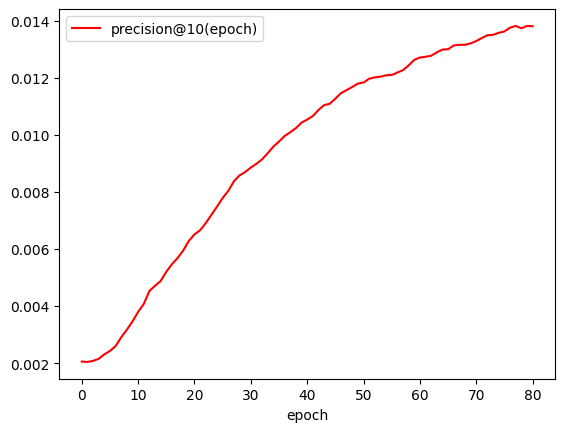

In [15]:
# TODO 1.4: Plot learning curve precision@k(epoch)
figure, ax = pl.subplots()

ax.plot(list(range(len(precisions_at))), precisions_at, "r", label="precision@10(epoch)")

ax.set_xlabel("epoch")
ax.legend()

pass

## Save track embeddings

In [16]:
BOTIFY_DATA_DIR = "/Users/n.anokhin/Projects/recsys-course/botify/data/"

In [17]:
biases, embeddings = model.get_item_representations()

In [18]:
model.item_biases *= 0.0

In [19]:
track_meta = pd.read_json(BOTIFY_DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [20]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [21]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [22]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [23]:
with open(BOTIFY_DATA_DIR + "recommendations_lfm.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-30:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": [int(x) for x in top]
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9708/9708 [00:07<00:00, 1380.16it/s]
